In this exercise, we will compare the result when rotating the features of the style image. For the rotated image, we will combine the features of rotating the image by 90 and 180 degrees.

# Import libs

In [20]:
from PIL import Image

import torchvision.transforms as transforms
from torchvision.models import vgg19 , VGG19_Weights
import torch.optim as optim
import torch.nn as nn
import torch

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

In [22]:
IMG_SIZE = 256

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def img_loader(path):
    img = Image.open(path).convert('RGB')
    img = img_transform(img).unsqueeze(0)
    return img.to(device, dtype=torch.float)

In [23]:
img_style1 = img_loader('style_img.jpg')
img_style2 = img_loader('style_img2.jpg')

img_content = img_loader('content_img.jpg')

# Loss functions

In [24]:
def gram_matrix(x):
    a, b,c,d = x.size()  # a=batch size(=1)
    x = x.view(a * b, c * d)  # resize F_XL into \hat F_XL
    G = torch.mm(x, x.t()) # compute the gram product
    return G.div(a * b * c * d)  # we 'normalize' the values by dividing by the number of element in the feature maps

content_weight = 1
style_weight = 1e6

content_loss = nn.MSELoss()
style_loss = nn.MSELoss()

# Model

In [25]:
backbone = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
backbone.to(device)

for param in backbone.parameters():
    param.requires_grad = False

# Features extract

In [26]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
        self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

normalization = Normalization().to(device)

C:\Users\admin\AppData\Local\Temp\ipykernel_17004\1740699474.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
C:\Users\admin\AppData\Local\Temp\ipykernel_17004\1740699474.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)


In [27]:
content_layer = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_features(model, img):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = img
    x = normalization(x)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Get style extract

In [28]:
def rot_style_features(style_features, style_layers):
    final_style_features = {}
    for layer in style_layers:
        sf = style_features[layer].clone()
        # Rotate by 90 degrees
        sf_90 = torch.rot90(sf.clone(), 1, [2, 3])
        # Rotate by 180 degrees
        sf_180 = torch.rot90(sf_90.clone(), 1, [2, 3])
        # Combine the original and rotated features
        final_rot = sf + (sf_90 - sf_180)

        final_style_features[layer] = final_rot
    return final_style_features

In [29]:
content_features = get_features(backbone, img_content)
style_features = get_features(backbone, img_style1)
final_style_features = rot_style_features(style_features, style_layers)

# Training

In [30]:
target_img1 = img_content.clone().requires_grad_(True).to(device)
target_img2 = img_content.clone().requires_grad_(True).to(device)
optimizer1 = optim.Adam([target_img1], lr=0.02)
optimizer2 = optim.Adam([target_img2], lr=0.02)

In [31]:
def style_transfer(model, optimizer, target_img, content_features, style_features, content_weight, style_weight):
    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0 , 1)
    target_features = get_features(model, target_img)
    content_loss_value = content_loss(target_features[content_layer[0]], content_features[content_layer[0]])

    style_loss_value = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss_value += style_loss(target_gram, style_gram)

    total_loss = content_weight * content_loss_value + style_weight * style_loss_value
    total_loss.backward(retain_graph=True)
    optimizer.step()
    return total_loss, content_loss_value, style_loss_value

In [32]:
EPOCHS = 500

for i in range(EPOCHS):
    total_loss1, content_loss1, style_loss1 = style_transfer(backbone, optimizer1, target_img1, content_features, style_features, content_weight, style_weight)
    total_loss2, content_loss2, style_loss2 = style_transfer(backbone, optimizer2, target_img2, content_features, final_style_features, content_weight, style_weight)

    if i % 100 == 99:
        print(f"Epoch {i+1}/{EPOCHS}, "
              f"Total Loss 1: {total_loss1.item():.4f}, "
              f"Content Loss 1: {content_loss1.item():.4f}, "
              f"Style Loss 1: {style_loss1.item():.4f}")

        print(f"Epoch {i+1}/{EPOCHS}, "
              f"Total Loss 2: {total_loss2.item():.4f}, "
              f"Content Loss 2: {content_loss2.item():.4f}, "
              f"Style Loss 2: {style_loss2.item():.4f}")

Epoch 100/500, Total Loss 1: 51.5302, Content Loss 1: 28.9289, Style Loss 1: 0.0000
Epoch 100/500, Total Loss 2: 626.6668, Content Loss 2: 53.1500, Style Loss 2: 0.0006
Epoch 200/500, Total Loss 1: 44.6090, Content Loss 1: 27.9217, Style Loss 1: 0.0000
Epoch 200/500, Total Loss 2: 526.7144, Content Loss 2: 56.2116, Style Loss 2: 0.0005
Epoch 300/500, Total Loss 1: 63.3413, Content Loss 1: 28.5006, Style Loss 1: 0.0000
Epoch 300/500, Total Loss 2: 490.7579, Content Loss 2: 57.4566, Style Loss 2: 0.0004
Epoch 400/500, Total Loss 1: 37.8087, Content Loss 1: 25.9946, Style Loss 1: 0.0000
Epoch 400/500, Total Loss 2: 524.0015, Content Loss 2: 57.8128, Style Loss 2: 0.0005
Epoch 500/500, Total Loss 1: 38.6511, Content Loss 1: 26.3505, Style Loss 1: 0.0000
Epoch 500/500, Total Loss 2: 457.1418, Content Loss 2: 58.8394, Style Loss 2: 0.0004


# See the results

In [35]:
# Get the final image
final_img1 = target_img1.clone().detach().cpu()
final_img1 = final_img1.squeeze(0).permute(1, 2, 0).numpy()
final_img1 = (final_img1 * 255).astype('uint8')
final_img1 = Image.fromarray(final_img1)
final_img1.save('Ex2_output_img1.jpg')

final_img2 = target_img2.clone().detach().cpu()
final_img2 = final_img2.squeeze(0).permute(1, 2, 0).numpy()
final_img2 = (final_img2 * 255).astype('uint8')
final_img2 = Image.fromarray(final_img2)
final_img2.save('Ex2_output_img2.jpg')

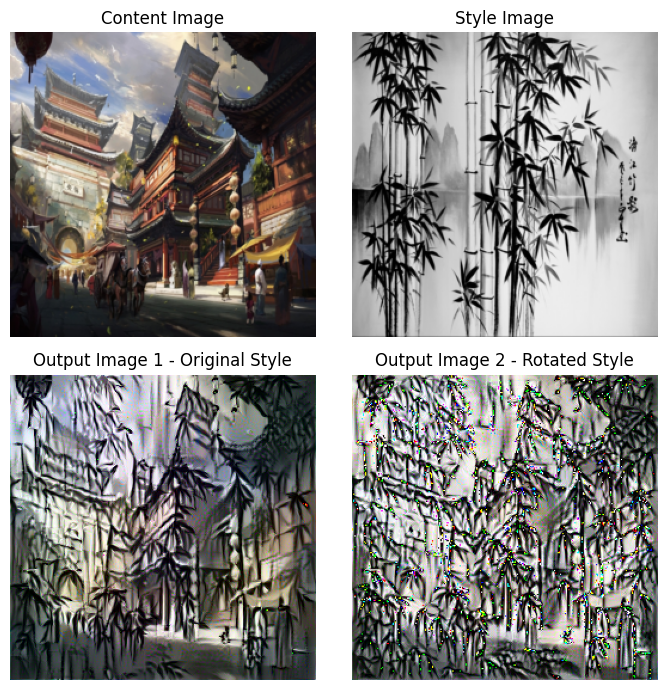

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].imshow(img_content.cpu().squeeze(0).permute(1, 2, 0).numpy())
ax[0, 0].set_title('Content Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(img_style1.cpu().squeeze(0).permute(1, 2, 0).numpy())
ax[0, 1].set_title('Style Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(final_img1)
ax[1, 0].set_title('Output Image 1 - Original Style')
ax[1, 0].axis('off')

ax[1, 1].imshow(final_img2)
ax[1, 1].set_title('Output Image 2 - Rotated Style')
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()
